### Import custom modules from current folder

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import nltk
from sklearn.model_selection import train_test_split
from simple_text_representation.classes import Text
from simple_text_representation.models import Database
import numpy as np
# from nltk.draw.tree import draw_trees

In [3]:
database = Database('educationalTexts', 'postgres', '', '0.0.0.0', 5432)
path = r'http://localhost/'

In [4]:
def transformToString(text):
    textStr = ''

    for paragraph in text:
        for line in paragraph:
            textStr = textStr + line
    return textStr

In [5]:
textOfSeventhGrade = Text.getTexts(database, grade=7)
textOfEightGrade = Text.getTexts(database, grade=8)
textOfNineGrade = Text.getTexts(database, grade=9)
textOfTenthGrade = Text.getTexts(database, grade=10)
textOfEleventhGrade = Text.getTexts(database, grade=11)

textsFormatedSG = [transformToString(textArr) for textArr in textOfSeventhGrade]
textsFormatedEG = [transformToString(textArr) for textArr in textOfEightGrade]
textsFormatedNG = [transformToString(textArr) for textArr in textOfNineGrade]
textsFormatedTG = [transformToString(textArr) for textArr in textOfTenthGrade]
textsFormatedEG = [transformToString(textArr) for textArr in textOfEleventhGrade]

### Format train and test data

In [6]:
data = np.concatenate((np.array(textsFormatedSG),
                       np.array(textsFormatedEG),
                       np.array(textsFormatedNG),
                       np.array(textsFormatedTG),
                       np.array(textsFormatedEG)  )) 
labels = np.concatenate((np.full(len(textsFormatedSG), 0),
                         np.full(len(textsFormatedEG), 1),
                         np.full(len(textsFormatedNG), 2),
                         np.full(len(textsFormatedTG), 3),
                         np.full(len(textsFormatedEG), 4)))

In [7]:
len(data)

175

In [8]:
len(labels)

175

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [10]:
len(y_train)

140

In [11]:
len(x_train)

140

### Load the trained embeddings

In [12]:
EMBEDDINGS_DIMESION = 300

In [13]:
embeddingsIndex = dict()
f = open('../SBW-vectors-300-min5.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddingsIndex[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddingsIndex))

Loaded 1000654 word vectors.


### Preprocesing the data

In [14]:
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/Users/herbert/.pyenv/versions/anaconda3-5.0.1/envs/jupyter3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
def createEmbedingMatrix(tokenizer, vocabSize):
    embeddingMatrix = np.zeros((vocabSize, 300))
    for word, i in tokenizer.word_index.items():
        embeddingVector = embeddingsIndex.get(word)
        if embeddingVector is not None:
            embeddingMatrix[i] = embeddingVector
    return embeddingMatrix

In [16]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    vocabSize = len(tokenizer.word_index) + 1
    encodedData = tokenizer.texts_to_sequences(x)
    maxLength = 500
    paddedData = pad_sequences(encodedData, maxlen=maxLength, padding='post')
    embeddings = createEmbedingMatrix(tokenizer, vocabSize)
    
    return paddedData

In [17]:
def createTrainData(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    vocabSize = len(tokenizer.word_index) + 1
    encodedData = tokenizer.texts_to_sequences(x)
    maxLength = 500
    paddedData = pad_sequences(encodedData, maxlen=maxLength, padding='post')
    embeddings = createEmbedingMatrix(tokenizer, vocabSize)
    
    return paddedData, embeddings, maxLength, vocabSize

In [18]:
x_train_tokenize, x_train_embeddings, x_train_max_features, x_train_vocab_size  = createTrainData(x_train)
x_test_tokenize = tokenize(x_test)

In [19]:
x_train_embeddings.shape

(11462, 300)

In [20]:
len(x_test_tokenize)

35

In [21]:
len(x_train_tokenize)

140

### Creating the model

In [22]:
print(__doc__)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM
from keras.optimizers import Adam

import itertools

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

np.random.seed(7)

Automatically created module for IPython interactive environment


In [23]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
def testModels(paramsArr):
    resultMetrics = list();
    resultPredict = list();
    
    for params in paramsArr:
        batch_size = params[0]
        numOfCells = params[1]
        epochs = params[2]
        # Model definition
        model = Sequential()
        adam = Adam(lr=0.001)
        embeddingLayer = Embedding(x_train_vocab_size,
                                   EMBEDDINGS_DIMESION,
                                   weights=[x_train_embeddings],
                                   input_length=x_train_max_features,
                                   trainable=False)
        model.add(embeddingLayer)
        model.add(LSTM(numOfCells))
        model.add(Dropout(0.1))
        model.add(Dense(5, activation='softmax'))
        model.compile(loss='sparse_categorical_crossentropy', optimizer=adam)
        # Model Train
        model.fit(x_train_tokenize, y_train, epochs=epochs, batch_size=batch_size)
        # Model Prediction
        y_predict = model.predict(x_test_tokenize)
        y = np.argmax(y_predict, axis=1)
        # Metrics calculation
        f1_result_score = f1_score(y_test, y, average='macro')
        precision_result_score = precision_score(y_test, y, average='macro')
        recall_result_score = recall_score(y_test, y, average='macro')
        accuracy_result_score = accuracy_score(y_test, y)
        resultPredict.append(y)
        resultMetrics.append([f1_result_score, precision_result_score, recall_result_score, accuracy_result_score])

    return resultMetrics, resultPredict

In [25]:
testParams = [
  [22, 100, 10],
  [32, 4, 10],
  [64, 16, 20],
  [32, 16, 20],
  [64, 32, 30],
  [64, 100, 30],
  [32, 32, 30],
  [64, 64, 40],
  [64, 64, 40],
]

In [26]:
testParams2 = [
  [32, 16, 20],
  [32, 32, 20],
  [32, 64, 20],
  [32, 128, 20],
  [32, 256, 20],
  [64, 64, 40],
  [64, 128, 40],
  [64, 256, 40],
]

In [27]:
metrics, predictions = testModels(testParams)

Epoch 1/10
140/140 [==============================] - 4s 31ms/step - loss: 1.5954
Epoch 2/10
140/140 [==============================] - 4s 28ms/step - loss: 1.5540
Epoch 3/10
140/140 [==============================] - 4s 27ms/step - loss: 1.5153
Epoch 4/10
140/140 [==============================] - 4s 28ms/step - loss: 1.4933
Epoch 5/10
140/140 [==============================] - 4s 27ms/step - loss: 1.4533
Epoch 6/10
140/140 [==============================] - 4s 26ms/step - loss: 1.4244
Epoch 7/10
140/140 [==============================] - 4s 27ms/step - loss: 1.4264
Epoch 8/10
140/140 [==============================] - 4s 25ms/step - loss: 1.4113
Epoch 9/10
140/140 [==============================] - 3s 24ms/step - loss: 1.3816
Epoch 10/10
140/140 [==============================] - 3s 24ms/step - loss: 1.3630


/Users/herbert/.pyenv/versions/anaconda3-5.0.1/envs/jupyter3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/herbert/.pyenv/versions/anaconda3-5.0.1/envs/jupyter3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/10
140/140 [==============================] - 3s 21ms/step - loss: 1.6119
Epoch 2/10
140/140 [==============================] - 2s 16ms/step - loss: 1.6101
Epoch 3/10
140/140 [==============================] - 2s 15ms/step - loss: 1.6075
Epoch 4/10
140/140 [==============================] - 2s 15ms/step - loss: 1.6059
Epoch 5/10
140/140 [==============================] - 2s 16ms/step - loss: 1.6028
Epoch 6/10
140/140 [==============================] - 2s 16ms/step - loss: 1.6014
Epoch 7/10
140/140 [==============================] - 2s 15ms/step - loss: 1.5989
Epoch 8/10
140/140 [==============================] - 2s 16ms/step - loss: 1.5981
Epoch 9/10
140/140 [==============================] - 2s 16ms/step - loss: 1.5962
Epoch 10/10
140/140 [==============================] - 2s 16ms/step - loss: 1.5948
Epoch 1/20
140/140 [==============================] - 2s 17ms/step - loss: 1.6021
Epoch 2/20
140/140 [==============================] - 1s 9ms/step - loss: 1.5920
Epoch 3/20
140/1

140/140 [==============================] - 1s 10ms/step - loss: 1.3960
Epoch 20/40
140/140 [==============================] - 2s 11ms/step - loss: 1.3791
Epoch 21/40
140/140 [==============================] - 1s 10ms/step - loss: 1.3659
Epoch 22/40
140/140 [==============================] - 1s 10ms/step - loss: 1.3570
Epoch 23/40
140/140 [==============================] - 1s 11ms/step - loss: 1.3686
Epoch 24/40
140/140 [==============================] - 2s 11ms/step - loss: 1.3492
Epoch 25/40
140/140 [==============================] - 2s 11ms/step - loss: 1.3496
Epoch 26/40
140/140 [==============================] - 2s 11ms/step - loss: 1.3346
Epoch 27/40
140/140 [==============================] - 1s 10ms/step - loss: 1.3357
Epoch 28/40
140/140 [==============================] - 1s 10ms/step - loss: 1.3042
Epoch 29/40
140/140 [==============================] - 1s 10ms/step - loss: 1.3310
Epoch 30/40
140/140 [==============================] - 1s 11ms/step - loss: 1.3594
Epoch 31/40
140/

In [28]:
CLASSES = ["Seventh Grade", "Eighth Grade", "Ninth grade", "Tenth grade", "Eleven grade"]

In [29]:
confusionMatrixs = list()

for prediction in predictions:
    confusionMatrix = confusion_matrix(y_test, prediction)
    np.set_printoptions(precision=2)
    confusionMatrixs.append(confusionMatrix)

In [30]:
len(confusionMatrixs)

9

In [31]:
metrics

[[0.156078431372549, 0.12, 0.22333333333333333, 0.34285714285714286],
 [0.1564835164835165,
  0.12065217391304348,
  0.22333333333333333,
  0.34285714285714286],
 [0.12941176470588237, 0.1, 0.18333333333333332, 0.3142857142857143],
 [0.2161904761904762,
  0.16422360248447204,
  0.3233333333333333,
  0.37142857142857144],
 [0.15428571428571428,
  0.11231884057971016,
  0.2833333333333333,
  0.34285714285714286],
 [0.20571428571428568,
  0.16231884057971016,
  0.2833333333333333,
  0.42857142857142855],
 [0.18285714285714288,
  0.1356521739130435,
  0.2833333333333333,
  0.34285714285714286],
 [0.20571428571428568,
  0.22065217391304345,
  0.3083333333333333,
  0.37142857142857144],
 [0.21013431013431014,
  0.23166666666666663,
  0.2483333333333333,
  0.37142857142857144]]

Confusion matrix, without normalization
[[11  0  1  0  0]
 [ 3  0  1  0  4]
 [ 1  0  0  0  1]
 [ 3  0  1  0  4]
 [ 4  0  0  0  1]]


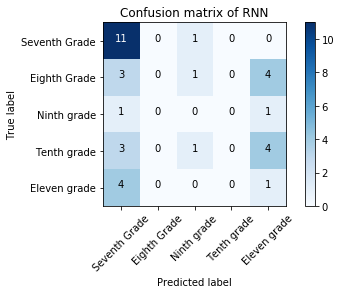

In [32]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[0], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[11  0  1  0  0]
 [ 3  0  1  0  4]
 [ 1  0  0  0  1]
 [ 4  0  2  0  2]
 [ 4  0  0  0  1]]


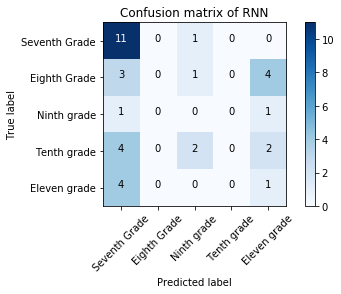

In [33]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[1], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[11  0  1  0  0]
 [ 3  0  3  0  2]
 [ 1  0  0  0  1]
 [ 3  0  3  0  2]
 [ 4  0  1  0  0]]


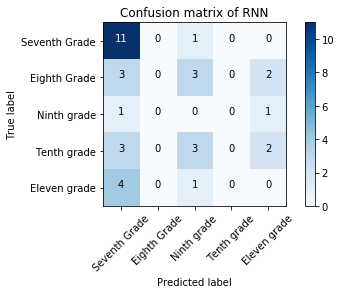

In [34]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[2], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[11  0  1  0  0]
 [ 3  0  1  0  4]
 [ 1  0  1  0  0]
 [ 4  0  2  0  2]
 [ 4  0  0  0  1]]


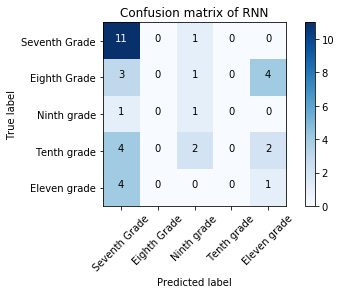

In [35]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[3], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[11  0  1  0  0]
 [ 3  0  5  0  0]
 [ 1  0  1  0  0]
 [ 4  0  4  0  0]
 [ 4  0  1  0  0]]


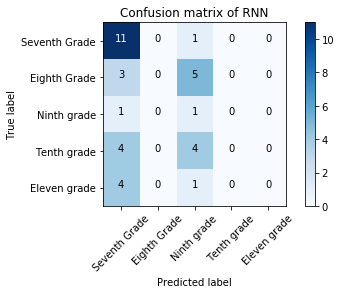

In [36]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[4], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[11  0  0  1  0]
 [ 3  0  0  5  0]
 [ 1  0  0  1  0]
 [ 4  0  0  4  0]
 [ 4  0  0  1  0]]


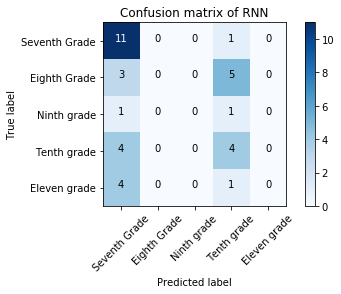

In [37]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[5], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[11  0  0  0  1]
 [ 3  0  2  1  2]
 [ 1  0  1  0  0]
 [ 4  1  2  0  1]
 [ 4  0  0  1  0]]


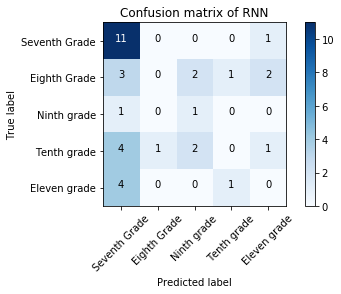

In [38]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[6], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[11  0  1  0  0]
 [ 3  0  3  1  1]
 [ 1  0  1  0  0]
 [ 4  1  2  1  0]
 [ 4  0  1  0  0]]


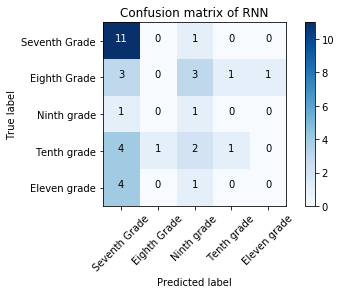

In [39]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[7], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[11  0  1  0  0]
 [ 3  0  2  3  0]
 [ 1  0  0  1  0]
 [ 5  0  1  1  1]
 [ 4  0  0  0  1]]


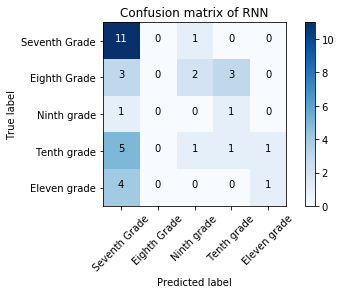

In [40]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[8], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[16  0  0  0  1]
 [ 3  0  0  0  8]
 [ 2  0  1  0  4]
 [ 3  0  2  0  6]
 [ 9  0  0  0  3]]


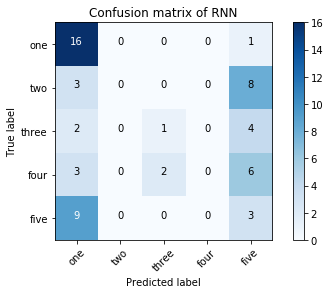

In [101]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrix, classes=["one","two","three","four","five"], title=plot_title)

Normalized confusion matrix
[[0.94 0.   0.   0.   0.06]
 [0.27 0.   0.   0.   0.73]
 [0.29 0.   0.14 0.   0.57]
 [0.27 0.   0.18 0.   0.55]
 [0.75 0.   0.   0.   0.25]]


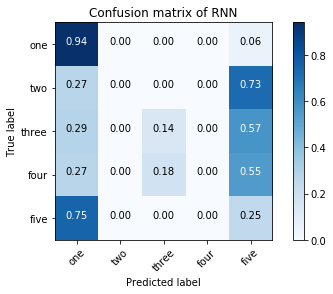

In [36]:
plot_confusion_matrix(confusionMatrix, classes=["one","two","three","four","five"], title=plot_title, normalize=True)